In [1]:
import torch
from torchvision import datasets
from torchvision import transforms
import matplotlib.pyplot as plt

# Transforms images to a PyTorch Tensor
tensor_transform = transforms.ToTensor()

# Download the MNIST Dataset
dataset = datasets.MNIST(root="./data",
                         train=True,
                         download=True,
                         transform=tensor_transform)

# DataLoader is used to load the dataset
# for training
loader = torch.utils.data.DataLoader(dataset=dataset,
                                     batch_size=1024,
                                     shuffle=True,
                                     drop_last=True)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

/home/ubuntu/miniconda3/envs/uer/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


100%|██████████| 9912422/9912422 [00:02<00:00, 4326401.59it/s]


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw



100%|██████████| 28881/28881 [00:00<00:00, 1343548.69it/s]


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 1703043.17it/s]


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 14069814.45it/s]


Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



device(type='cuda', index=0)

In [2]:
# Creating a PyTorch class
# 28*28 ==> 9 ==> 28*28
class AE(torch.nn.Module):
    def __init__(self):
        super().__init__()

        # Building an linear encoder with Linear
        # layer followed by Relu activation function
        # 784 ==> 9
        self.encoder = torch.nn.Sequential(
            torch.nn.Linear(28 * 28, 128),
            torch.nn.ReLU(),
            torch.nn.Linear(128, 64),
            torch.nn.ReLU(),
            torch.nn.Linear(64, 36),
            torch.nn.ReLU(),
            torch.nn.Linear(36, 18),
            torch.nn.ReLU(),
            torch.nn.Linear(18, 9)
        )

        # Building an linear decoder with Linear
        # layer followed by Relu activation function
        # The Sigmoid activation function
        # outputs the value between 0 and 1
        # 9 ==> 784
        self.decoder = torch.nn.Sequential(
            torch.nn.Linear(9, 18),
            torch.nn.ReLU(),
            torch.nn.Linear(18, 36),
            torch.nn.ReLU(),
            torch.nn.Linear(36, 64),
            torch.nn.ReLU(),
            torch.nn.Linear(64, 128),
            torch.nn.ReLU(),
            torch.nn.Linear(128, 28 * 28),
            torch.nn.Sigmoid()
        )

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded


In [8]:
# Model Initialization
model = AE()

# Validation using MSE Loss function
loss_function = torch.nn.MSELoss()

# Using an Adam Optimizer with lr = 0.1
optimizer = torch.optim.AdamW(model.parameters(),lr=1e-3)

In [9]:
import tqdm
epochs = 20

for epoch in range(epochs):
    for image, _ in (pbar:=tqdm.tqdm(loader)):
        # Reshaping the image to (-1, 784)
        image = image.reshape(-1, 28*28)

        # Output of Autoencoder
        reconstructed = model(image)

        # Calculating the loss function
        loss = loss_function(reconstructed, image)

        # The gradients are set to zero,
        # the gradient is computed and stored.
        # .step() performs parameter update
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # show the loss
        pbar.set_description(f"Epoch: {epoch+1}, Loss: {loss.item():.4f}")


Epoch: 20, Loss: 0.0392: 100%|██████████| 59/59 [00:04<00:00, 12.71it/s]


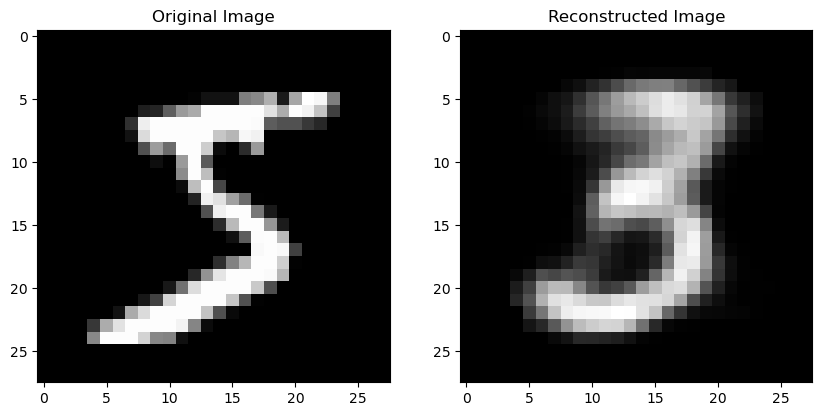

In [10]:
# Plotting the reconstructed image
# and the original image
def plot_image(image, reconstructed):
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.imshow(image.reshape(28, 28), cmap="gray")
    plt.title("Original Image")
    plt.subplot(1, 2, 2)
    plt.imshow(reconstructed.reshape(28, 28), cmap="gray")
    plt.title("Reconstructed Image")
    plt.show()

# pick a random image
image, _ = dataset[0]
plot_image(image, model(image.reshape(-1, 28*28)).detach())

In [2]:
import numpy as np

class FFUnit(torch.nn.Module):
    def __init__(self, input_size, output_size, lr=1e-3, activation=None):
        super().__init__()
        self.input_size = input_size
        self.output_size = output_size
        self.lr = lr

        self.W = torch.nn.Linear(input_size, output_size)
        self.actv = activation

        self.loss = torch.nn.MSELoss()
        self.optimizer = torch.optim.AdamW(self.parameters(),lr=lr)
    
    def init_parameters(self, img, times=10):
        ae_tmp = torch.nn.Sequential(
            self.W,
            torch.nn.Linear(self.output_size, self.input_size)
        ).to(device)
        optimizer_tmp = torch.optim.AdamW(ae_tmp.parameters(),lr=1e-3)

        all_loss = []
        for i in range(times):
            x = ae_tmp[0](img)
            img_out = ae_tmp[1](x)
            loss = self.loss(img, img_out)
            optimizer_tmp.zero_grad()
            loss.backward()
            optimizer_tmp.step()
            all_loss.append(loss.detach().cpu().numpy())
        return np.mean(all_loss), x.detach() 

    def update(self, new_in, past_out):
        new_out = self.W(new_in)
        if self.actv is not None:
            new_out = self.actv(new_out)

        # 由于autoencoder的原理，我们可以估计理想的l(F(x))应该等价于一个线性模型 y = x
        # l(F(past_out)) = l(new) = past_out
        loss = self.loss(past_out, new_out)

        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

        return loss.detach(), self.forward(new_in)

    def forward(self, x):
        with torch.no_grad():
            new_out = new_out = self.W(x)
            if self.actv is not None:
                new_out = self.actv(new_out)
        return new_out

In [19]:
import tqdm
import numpy as np


class FFAE(torch.nn.Module):
    def __init__(self, eps=1e-2, init_dataloader=None):
        super().__init__()
        self.eps = eps
        self.units = torch.nn.Sequential(
            FFUnit(28*28, 128, lr=1e-1 ,activation=torch.nn.LeakyReLU()),
            FFUnit(128, 64, lr=1e-3 , activation=torch.nn.LeakyReLU()),
            FFUnit(64, 36,  lr=1e-3 ,activation=torch.nn.LeakyReLU()),
            FFUnit(36, 18,  lr=1e-3 , activation=torch.nn.LeakyReLU()),
            FFUnit(18, 9,lr=1e-3 ),
            FFUnit(9, 18,lr=1e-3 ),
            FFUnit(18, 36,  lr=1e-3 ,activation=torch.nn.LeakyReLU()),
            FFUnit(36, 64,  lr=1e-3 ,activation=torch.nn.LeakyReLU()),
            FFUnit(64, 128, lr=1e-3 , activation=torch.nn.LeakyReLU()),
            FFUnit(128, 28*28,  lr=1e-3, activation=torch.nn.Sigmoid()),
        )
        self.loss = torch.nn.MSELoss()

        if init_dataloader is not None:
            for image, _ in (pbar := tqdm.tqdm(loader)):
                # Reshaping the image to (-1, 784)
                x = image.reshape(-1, 28*28).to(device)
                loss = 0
                for unit in self.units:
                    loss, x = unit.init_parameters(x)
                pbar.set_description(f"Loss: {loss.item():.4f}")
        self.buffer = []

    def forward(self, x):
        with torch.no_grad():
            x = self.units(x)
        return x

    def update(self, img):
        # img = x.clone().detach()
        x = img.clone().detach()
        if len(self.buffer) == 0:
            with torch.no_grad():
                for unit in self.units:
                    x = unit(x)
                    self.buffer.append(x)
       
        _ = self.units[0].update(self.buffer.pop(-1), self.buffer.pop(0))
        x = self.units[0](img)
        self.buffer.append(x)
        for unit in self.units[1:-1]:
            _, x = unit.update(x, self.buffer.pop(0))
            self.buffer.append(x)

        loss, x = self.units[-1].update(x, img)
        self.buffer.append(x)
        return loss.detach().cpu().numpy()


In [20]:
model = FFAE(init_dataloader=loader).to(device)

Loss: 0.0056: 100%|██████████| 58/58 [00:09<00:00,  6.07it/s]


In [21]:
epochs = 20
times = 10

for epoch in range(epochs):
    # times //= 2
    # times = max(times, 10)
    for image, _ in (pbar:=tqdm.tqdm(loader)):
        # Reshaping the image to (-1, 784)
        image = image.reshape(-1, 28*28).to(device)
        
        
        loss = model.update(image)
      
        # show the loss
        pbar.set_description(f"Epoch: {epoch+1}, Loss: {loss.item():.4f}")

Epoch: 20, Loss: 0.0716: 100%|██████████| 58/58 [00:03<00:00, 15.86it/s]


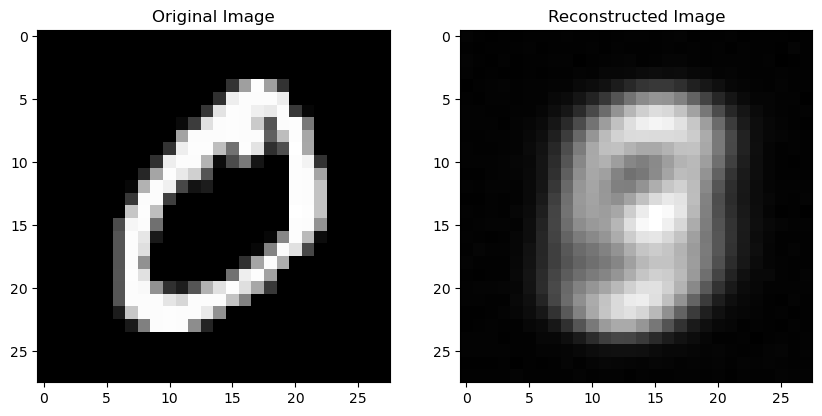

In [22]:
# Plotting the reconstructed image
# and the original image
def plot_image(image, reconstructed):
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.imshow(image.reshape(28, 28), cmap="gray")
    plt.title("Original Image")
    plt.subplot(1, 2, 2)
    plt.imshow(reconstructed.reshape(28, 28), cmap="gray")
    plt.title("Reconstructed Image")
    plt.show()

# pick a random image
image, _ = dataset[1]
plot_image(image, model(image.reshape(-1, 28*28).to(device)).detach().cpu())

In [3]:
import torch
a = torch.tensor([[1.0, 4.0, 3.0],
        [2.0, 7.0, 6.0],
        [5.0, 8.0, 9.0]])

torch.inverse(a)

tensor([[ 2.5000, -2.0000,  0.5000],
        [ 2.0000, -1.0000,  0.0000],
        [-3.1667,  2.0000, -0.1667]])

In [5]:
b = a + 1
torch.inverse(b)

tensor([[ 1.7000, -1.4000,  0.3000],
        [ 1.2000, -0.4000, -0.2000],
        [-2.1000,  1.2000,  0.1000]])

In [6]:
a/b

tensor([[0.5000, 0.8000, 0.7500],
        [0.6667, 0.8750, 0.8571],
        [0.8333, 0.8889, 0.9000]])

In [7]:
a@torch.inverse(b)

tensor([[ 0.2000,  0.6000, -0.2000],
        [-0.8000,  1.6000, -0.2000],
        [-0.8000,  0.6000,  0.8000]])

In [10]:
test = torch.nn.Parameter(torch.randn(8, 5))
test_var = torch.randn(8)
test_var @ test 

tensor([ 4.5348,  2.5690, -0.0067, -1.3955, -1.0628],
       grad_fn=<SqueezeBackward3>)

In [ ]:
# 3 -> m1 -> a
# a -> m2 -> 1

# (1, 3) -> m1 -> c
# c -> m2 -> 2

# (2, 3) -> m1 -> ?

In [ ]:
    
def update_by_guji(self, t_plus_2_out, t_plus_1_in, t_in):
    # past_past_out = self.relu(past_past @ self.W_past)
    # past = F(past_past_out)
    # past_out = self.sigmoid(past @ self.W)
    # past_out = past @ self.W
    # new = F(past_out)
    # diff = new - past # which expected to be 0
    # new_out = self.sigmoid(new @ self.W)
    
    t_plus_1_out = self.relu(t_plus_1_in @ self.W)
    # t_in = F(t_plus_1_out)
    # t_plus_1_in = F(t_plus_2_out)
    # 如果t_plus_1_out和t_plus_2_out之间的改变不大，
    # 那么倒数g = (t_in - t_plus_1_in) / (t_plus_1_out - t_plus_2_out)
    g = (t_in - t_plus_1_in) / (t_plus_1_out - t_plus_2_out)

    # 作为一个autoencoder，我们希望past和new尽可能相近，并且导致这种改变的是因为self.W和self.W_past的改变
    
    # 如果past_out和past_past_out之间的改变不大，
    # 那么倒数g = (new - past) / (past_out - past_past_out)
    # g = (new - past) / (past_out - past_past_out)


    # new_out = self.relu(new @ self.W) # after update